### PROYECTO 2: modelo predictivo con pycaret

#### Importación librerías 

In [2]:
import pandas as pd
import numpy as np
from pycaret.classification import *
import pycaret
from pycaret.regression import *
from pycaret.datasets import get_data
from summarytools import dfSummary
import matplotlib.pyplot as plt

#### 1. Carga de datos

In [3]:
dataHouse = pd.read_csv("train.csv")
dataHouse.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### 2. Exploración de datos EDA

In [4]:
dfSummary(dataHouse)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Id[int64],Mean (sd) : 730.5 (421.6)min < med < max:1.0 < 730.5 < 1460.0IQR (CV) : 729.5 (1.7),"1,460 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy89olMNAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABUklEQVR4nO3WsUrDUBTH4ZPSC1ahAae8lmOfsKMP1aWL1Eilm3FxyNBW2sU/8n1LhsO5N8OPkG6apoIUi79+AZhbXhp0XbeoqvWd53Y/z3s+v3b/925V1cc0TV/nBheDrKr1ZrN56fv+dOttu93uubXWDcPwZtfu3DiOq+12+1pV7+fm14Ksvu9PwzB83nrp4XB4bK2VXbu38g9JFEESRZBEESRRBEkUQRJFkEQRJFEESRRBEkWQRBEkUQRJFEESRZBEESRRBEkUQRJFkEQRJFEESRRBEkWQRBEkUQRJFEESRZBEESRRBEkUQRJFkEQRJFEESRRBEkWQRBEkUQRJFEESRZBEESRRBEkUQRJFkEQRJFEESRRBEkWQRBEkUQRJFEESRZBEESRRBEkUQRJFkEQRJFEESRRBEmV5bTiO4+qeQ4/H40Nrrdvv90927c791tQ3ucefRh4PyjAAAAAASUVORK5CYII="">",0(0.0%)
2,MSSubClass[int64],Mean (sd) : 56.9 (42.3)min < med < max:20.0 < 50.0 < 190.0IQR (CV) : 50.0 (1.3),15 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy89olMNAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB0klEQVR4nO3csW7CMBhF4d+oSKWNsNQpD9UhHXlCxj4UC0uVJkqBhaQLAwsp2Lhc8PlW5GDBEXISYjcMgwEqJreeAHDs6dQLzrmJmc0jjt0Ow9BHjEeGTgZpZvPFYvHhvd9eetCmaWbL5fLTzL6DZ4YsjQVp3vttWZY//zUZgDUkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpBAkpIw+BnsLbFCQN7kgjQ0KsqYYJBsUZIw1JKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQQJKQk+cf4fr93ZuadcyHDfd/3QQNx/5IE2bbtrKqq97Isvy4du1qt3jabzc7MugRTg7hkz9QURRH0XExd1y8p5oP7wBoSUggSUggSUggSUiQ3CggVebnJLHAbFrZ/uZ6HCjLmclPkNixs/3IlDxWkWfjlplhs/3IdDxckzqO6zCDIgwxvd0ouMwjyIMfbnaHLjJQnjwR5hNud50l58kiQCJLq5JEL45Ay+gvZNM0s5KBd1z1Pp1O3Xq9fGTvu8BnHrMdC+Vt8v3+95y9RTM9OTpePYwAAAABJRU5ErkJggg=="">",0(0.0%)
3,MSZoning[object],1. RL2. RM3. FV4. RH5. C (all),"1,151 (78.8%)218 (14.9%)65 (4.5%)16 (1.1%)10 (0.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy89olMNAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB9klEQVR4nO3dscrTYBSA4aQUpIv5x95Uh47xBjt6a0aQ4mKcBBF/XJo3xT7PFRzoCznDd+i4rusAhcPeA/A6xEZGbGTGYRje9h6CxNd1XX/sOcBxnufrNE33PYdgW8uynG632+dhGL7sOcdxmqb7+Xz+tucQvAY7GxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTkuy3Laewi29Sy/sZe6r2P3l7qjUz4qdjYyYiOz9c62+57A89jsuupZLnp4Hq6ryNjZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzGbXVc9y0cPz8FKXjOsqMnY2MmIj86+dzc7Fw7x7XeU6ikdzXUXGzkZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTeva5yHcWjealLxnUVGTsbmd8/oz6ZbOowz/N1nufrMAwf9x6G/9txi/+tgr+xs5ERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnsv6vgT56Fk3FdRcbORuYwjuPbOI6iY3OHy+XyaXBZReBwOp2+7z0Er8Hnk4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOF+v3/Yewhew6/rKpdVbM51FRk7GxmxkREbmZ87v38JNDlubgAAAABJRU5ErkJggg=="">",0(0.0%)
4,LotFrontage[float64],Mean (sd) : 70.0 (24.3)min < med < max:21.0 < 69.0 < 313.0IQR (CV) : 21.0 (2.9),110 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy89olMNAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxklEQVR4nO3dMWsCMRyG8X+k0tqKsZ3uEzl1sNDFT+jYQfqJBHEp5x1Xr4uXrl0ULnr0zd3zWyUhwwOGQHIuhGCAitF/LwD4666LSZ1zIzObXTFFGUJobrUepKOTIM1stlqt3rz3dduBRVFM1uv1h5kdbr8sqOsqSPPe11mWfXc1P/qJPSSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkECSkdPYcX6zT6eTMzDvnYqfgsdOEyQVZluVkuVy+Zln21XYsj52mTy5IM7PpdMpjpwPFHhJSCBJSCBJSCBJSCBJSCBJSzh77XPk1Lt80TfTJNobr0jlk9Ne4ttvty/F4/DGzKn5pGKKLB+OxX+PK8/wxfkkYMvaQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkCJ56zAWd7rT16sgudOdvl4Facad7tT1LshY/N1ruBhkURSTmEmrqnoYj8duv98/pTJ2t9s9LxaL9/l8fmg7tq7r+81m8+mcK9qOHaIQwuHcb78n8n4eMTI9GwAAAABJRU5ErkJggg=="">",259(17.7%)
5,LotArea[int64],Mean (sd) : 10516.8 (9981.3)min < med < max:1300.0 < 9478.5 < 215245.0IQR (CV) : 4048.0 (1.1),"1,073 distinct va

#### 3. División de data para entrenamiento y prueba

In [5]:
num_filas_train = int(len(dataHouse)*0.8)

data_train = dataHouse.sample(n=num_filas_train, random_state=2023)
data_test = dataHouse.drop(data_train.index)

In [6]:
print(f"Filas en train: {data_train.shape[0]}")
print(f"Filas en test: {data_test.shape[0]}")

Filas en train: 1168
Filas en test: 292


#### 4. Descripción de advertencias

No logré realizar el profiling, a través de pycaret no encontré la manera de ejecutarlo correctamente sin utilizar el get data y el pandas-profiling no me permitió instalarlo adecuadamente. Sin embargo, al explorar la data se encontraron ciertas observaciones:

1. Los Nan de las variables categoricas si tienen un significado y regularmente es que no se cuenta con lo que se esta evaluando, por lo que la imputación debe ser a través de un valor especifico (No moda, KNN, etc.)

2. Se eliminarán columnas en las que sus variables poseen poca cardinalidad y tambien las que poseían más del 5% de nulos.

#### 5. Parametrización de modelo (Setup)

Como se mencionó en el punto anterior, respecto a la imputación de variables categoricas, se realizará con un valor especifíco debido a que los nulos tienen siginificado.

Para la imputación de variables númericas se trabajó la media, de igual manera se excluyeron las columnas con más de 5% de nulos.

Se realizó una lista de categorical_columns para que el setup genere correctamente la codificación de estas variables.

In [7]:
categorical_columns = data_train.select_dtypes(include='object').columns.tolist()

In [8]:
dataset = setup(data=data_train,
                target='SalePrice',
                session_id=2023,
                normalize=True,
                normalize_method='minmax',
                transformation=True,
                log_experiment=True,
                numeric_imputation = 'mean',
                categorical_imputation = 'str',
                categorical_features=categorical_columns,
                ignore_features=['LOTFRONTAGE','ALLEY', 'POOLQC','MISCFEATURE'],
                remove_outliers = True,
                encoding_method = True,
                experiment_name='House prices predict v1')

,Description,Value
0,Session id,2023
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1168, 81)"
4,Transformed data shape,"(1127, 282)"
5,Transformed train set shape,"(776, 282)"
6,Transformed test set shape,"(351, 282)"
7,Ignore features,4
8,Ordinal features,6
9,Numeric features,37


In [9]:
dataset

#### 6. Entrenamiento y selección de modelos

Los 3 modelos con mejores indicadores son:

1. Gradient Boosting Regressor (gbr)
2. Random Forest Regressor (rf)
3. Light Gradient Boosting Machine (lightgbm)

In [11]:
best = compare_models(sort='RMSE', n_select = 3, exclude=['lar','lr','br'],)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,17118.5971,764283555.6025,26177.8441,0.8651,0.1435,0.1042,0.8600
rf,Random Forest Regressor,18450.1267,913768725.2844,28952.5046,0.8409,0.1569,0.1128,1.1820
lightgbm,Light Gradient Boosting Machine,18006.0070,914626228.4086,29206.5067,0.8419,0.1520,0.1069,0.9680
huber,Huber Regressor,18694.5844,1018272402.3757,30607.8308,0.8250,0.1693,0.1082,0.7340
et,Extra Trees Regressor,19920.0312,993617767.0587,30859.6804,0.8302,0.1628,0.1181,1.1150
llar,Lasso Least Angle Regression,20330.0249,1076391854.2752,31302.3181,0.8123,0.2206,0.1237,0.7360
ridge,Ridge Regression,20610.8223,1103498471.0899,31695.7090,0.8079,0.2515,0.1242,0.6440
par,Passive Aggressive Regressor,20397.9400,1152308423.8933,33128.4599,0.8055,0.1513,0.1112,0.8790
ada,AdaBoost Regressor,24187.3722,1273469111.4080,34638.8365,0.7803,0.1975,0.1557,1.3490
omp,Orthogonal Matching Pursuit,23154.3054,1271547443.0513,34822.2033,0.7788,0.1909,0.1380,0.6360


In [12]:
best

[GradientBoostingRegressor(random_state=2023),
 RandomForestRegressor(n_jobs=-1, random_state=2023),
 LGBMRegressor(n_jobs=-1, random_state=2023)]

#### 6.a Gráficas de importancia de características

En los primeros dos modelos gbr y rf se observa que la variable que evalua el material y acabado de la casa, es una de las variables que mayor incidencia tienen, siendo la que le sigue la superficie habitable en pies cuadrados.

En el tercer modelo se observa una mejor composición en la importancia de las variables, siendo la de mayor relevancia la superficie habitable en pies cuadrados.

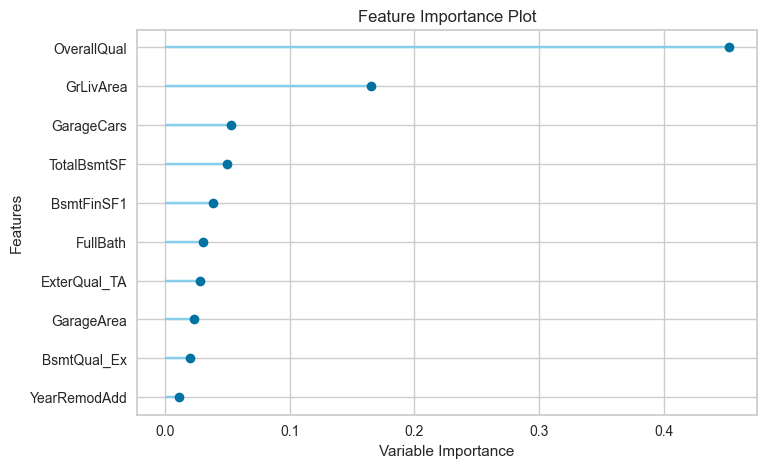

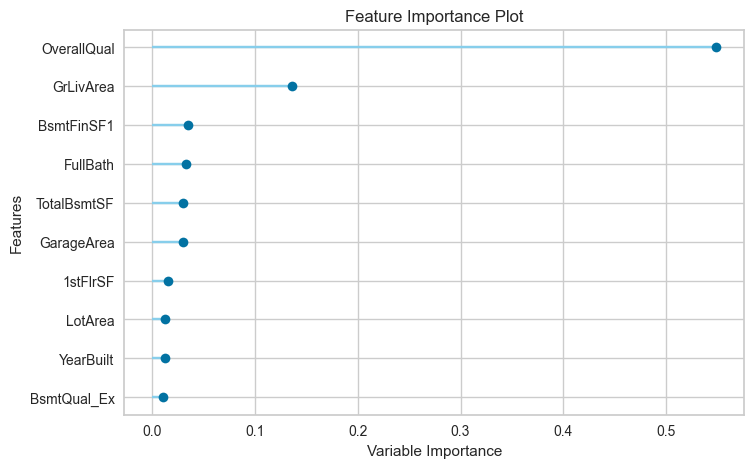

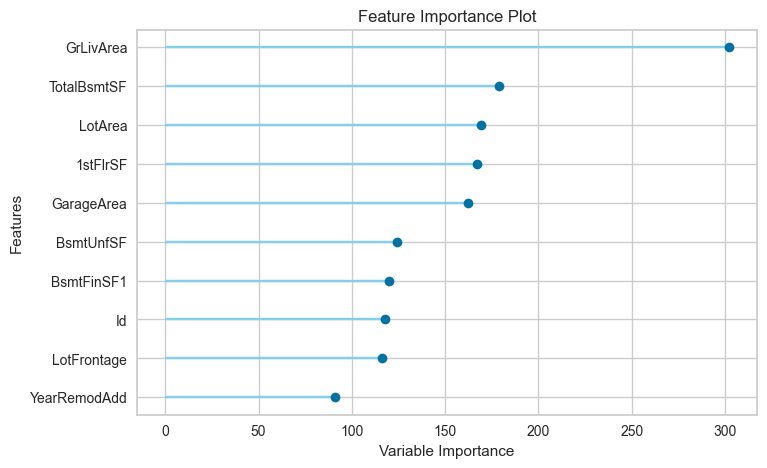

In [13]:
for i, model in enumerate(best, 1):
    plot_model(model, plot='feature')

In [14]:
model1 = best[0]
model1
model2 = best[1]
model2
model3 = best[2]
model3


LGBMRegressor(n_jobs=-1, random_state=2023)

#### 7. Optimización de hiper-parametros

In [15]:
tuned_model1 = tune_model(estimator=model1)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:21:03
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,25097.1168,2697126405.1534,51933.8657,0.4692,0.2487,0.1716
1,15239.5910,594387867.0152,24380.0711,0.9233,0.1116,0.0815
2,22238.1329,1193633138.8122,34548.9962,0.8634,0.1418,0.1086
3,17329.8217,646227960.7951,25421.0142,0.8816,0.1365,0.0940
4,17190.2750,589979966.3088,24289.5032,0.8849,0.1242,0.0917
5,17479.7593,535830822.8513,23148.0198,0.8842,0.1758,0.1283
6,16792.3878,575101062.0754,23981.2648,0.8988,0.1382,0.1018
7,13904.9052,350275477.5648,18715.6479,0.9386,0.1474,0.1003
8,16256.4316,415377348.2435,20380.8083,0.9266,0.1229,0.0971


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [16]:
tuned_model2 = tune_model(estimator=model2)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:22:47
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,26884.1076,2395859066.2878,48947.5134,0.5285,0.2497,0.1744
1,20850.5589,1258528751.1989,35475.7488,0.8376,0.1638,0.1190
2,25933.2973,1920713934.1634,43825.9505,0.7802,0.1727,0.1305
3,19780.6910,899352940.6903,29989.2137,0.8352,0.1514,0.1165
4,20136.9707,1003997448.9835,31685.9188,0.8042,0.1484,0.1018
5,19222.0586,952894708.1609,30868.9927,0.7941,0.2004,0.1448
6,19227.9709,727223966.8855,26967.0904,0.8721,0.1713,0.1277
7,19059.0504,944578744.9123,30733.9998,0.8345,0.1966,0.1383
8,20852.6562,726531902.3098,26954.2557,0.8717,0.1749,0.1361


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


#### 8. Selección del mejor modelo (Gradient Boosting Regressor)

In [21]:
bestmodel = create_model(tuned_model1)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:27:06
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,24086.4998,2597055801.4686,50961.3167,0.4889,0.2450,0.1639
1,15391.0790,569813904.5457,23870.7751,0.9265,0.1157,0.0869
2,19011.6341,990720400.4327,31475.7113,0.8866,0.1255,0.0939
3,18229.1044,610480432.7592,24707.9022,0.8881,0.1384,0.1030
4,16381.9036,539822464.0212,23234.0798,0.8947,0.1185,0.0888
5,16066.6090,593035187.3459,24352.3138,0.8718,0.1656,0.1129
6,15391.4557,442340191.9198,21031.8851,0.9222,0.1301,0.0976
7,13943.9085,329262672.6588,18145.5965,0.9423,0.1294,0.0965
8,16132.8676,437411664.8640,20914.3889,0.9227,0.1326,0.0996


#### 9. Almacenamiento del pipeline en disco duro

In [29]:
save_model(model=bestmodel,model_name= 'modelo_gbr')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Id', 'MSSubClass', 'LotFrontage',
                                              'LotArea', 'OverallQual',
                                              'OverallCond', 'YearBuilt',
                                              'YearRemodAdd', 'MasVnrArea',
                                              'BsmtFinSF1', 'BsmtFinSF2',
                                              'BsmtUnfSF', 'TotalBsmtSF',
                                              '1stFlrSF', '2ndFlrSF',
                                              'LowQualFinSF', 'GrLivArea',
                                              'BsmtFullBath', 'BsmtHalfBath',
                                              'FullBath', 'Hal...
                                                                     'GarageType', ...],
                                                               handle_missing='return_nan',


In [31]:
model=load_model('modelo_gbr')

Transformation Pipeline and Model Successfully Loaded


In [32]:
model

Pipeline(memory=FastMemory(location=C:\Users\PC2\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Id', 'MSSubClass', 'LotFrontage',
                                             'LotArea', 'OverallQual',
                                             'OverallCond', 'YearBuilt',
                                             'YearRemodAdd', 'MasVnrArea',
                                             'BsmtFinSF1', 'BsmtFinSF2',
                                             'BsmtUnfSF', 'TotalBsmtSF',
                                             '1stFlrSF', '2ndFlrSF',
                                             'LowQualFinSF', 'GrLivArea',
                                             'BsmtFu...
                                                                    'GarageType', ...],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('remove_outliers',
                 TransformerWrapper(transformer=RemoveOutliers(random_state=2023))),
                ('transformation',
                 TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                ('normalize', TransformerWrapper(transformer=MinMaxScaler())),
                ('trained_model',
                 GradientBoostingRegressor(random_state=2023))])

#### 10. Predicciones 

In [33]:
predicciones=predict_model(model, data=data_test)
predicciones

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,16795.4280,633615881.1392,25171.7278,0.8935,0.1355,0.1014


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,prediction_label
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,180500.056899
21,22,45,RM,57.0,7449,Pave,Grvl,Reg,Bnk,AllPub,...,NaN,GdPrv,NaN,0,6,2007,WD,Normal,139400,137360.639519
27,28,20,RL,98.0,11478,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2010,WD,Normal,306000,307529.563470
29,30,30,RM,60.0,6324,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2008,WD,Normal,68500,83432.935314
31,32,20,RL,NaN,8544,Pave,NaN,IR1,Lvl,AllPub,...,NaN,MnPrv,NaN,0,6,2008,WD,Normal,149350,139663.274778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,1448,60,RL,80.0,10000,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2007,WD,Normal,240000,280725.577871
1449,1450,180,RM,21.0,1533,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2006,WD,Abnorml,92000,101792.665117
1451,1452,20,RL,78.0,9262,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2009,New,Partial,287090,253713.824950
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,168504.138768


#### 11. Cálculo de metricas de rendimiento

In [37]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
r2 = r2_score(data_test['SalePrice'], predicciones['prediction_label'])
rmse = mean_squared_error(data_test['SalePrice'], predicciones['prediction_label'], squared=False)
mse = mean_squared_error(data_test['SalePrice'], predicciones['prediction_label'])
mae = mean_absolute_error(data_test['SalePrice'], predicciones['prediction_label'])

# Mostrar las métricas
print(f'R2 Score: {r2}')
print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

R2 Score: 0.8934586289137698
RMSE: 25171.72781394219
MSE: 633615881.1391909
MAE: 16795.427972712587
